In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.regressor import generate_regressor_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["regressor"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['regressor']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-06 10:54:51.000843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 10:54:51.127065: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 10:54:51.688032: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_073
rm: cannot remove '/kaggle/output/exp_073': No such file or directory


In [2]:
sub = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,key_step,event,score,step,minutes
0,038441c925bb,5051.5,onset,0.834676,5039,1857.5
1,038441c925bb,10907.5,wakeup,0.754868,10895,2337.5
2,038441c925bb,20387.5,onset,0.630360,20375,2937.5
3,038441c925bb,27467.5,wakeup,0.880441,27455,2337.5
4,038441c925bb,40019.5,onset,0.879920,40007,297.5


,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


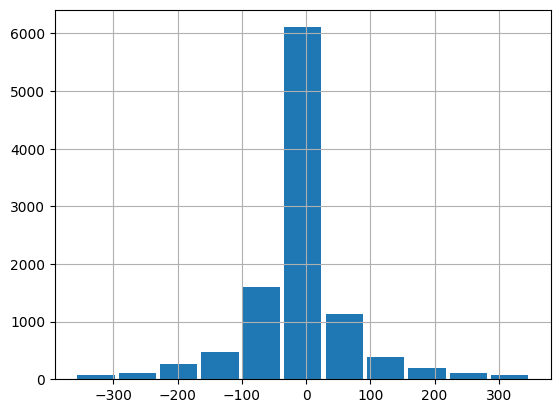

series_id     5331163
step          5331163
oof_stage2    5331163
minutes        877617
target          10508
sub_step        10508
key_step        10508
event           10508
score           10508
dtype: int64
82.34603297862218


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,event,score
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 正解ラベルを作成
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.empty(len(sub_df))
    for i, sub_step in enumerate(sub_df["step"].values):
        best_step = np.inf
        for step in label_df["step"].values:
            if abs(step - sub_step) < abs(best_step - sub_step):
                best_step = step
        target = best_step - sub_step
        if abs(target) > 360:
            target = 0
        targets[i] = target
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "key_step", "event", "score"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [4]:
# 特徴生成
train, features = generate_regressor_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:18<00:00,  1.39it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,event,score,for_pred,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,5051.5,0.120360,1857.5,-47.0,5039.0,5051.5,onset,0.834676,1.0,...,0.0,0.955621,-0.004250,0.706929,0.0,0.996829,-0.000130,0.899326,0.0,2
1,038441c925bb,10907.5,0.170375,2337.5,37.0,10895.0,10907.5,wakeup,0.754868,1.0,...,0.0,-0.954823,0.004947,-0.621952,0.0,-0.994158,0.000114,-0.797574,0.0,2
2,038441c925bb,20387.5,0.252375,2937.5,-131.0,20375.0,20387.5,onset,0.630360,1.0,...,0.0,0.911727,-0.014350,0.665582,0.0,0.990694,-0.000624,0.853023,0.0,2
3,038441c925bb,27467.5,0.775471,2337.5,37.0,27455.0,27467.5,wakeup,0.880441,1.0,...,0.0,-0.927675,0.009262,-0.646892,0.0,-0.992443,0.000357,-0.759777,0.0,2
4,038441c925bb,40019.5,0.175070,297.5,-11.0,40007.0,40019.5,onset,0.879920,1.0,...,0.0,0.938981,-0.004094,0.670728,0.0,0.993352,-0.000087,0.862998,0.0,2


(10508, 1385)

In [5]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["regressor"]["xgboost"], 
    es_rounds=100,
)
train["oof_regressor"] = trn_oof
train["key_step"] = train["step"]
train["sub_step_before_modify"] = train["sub_step"]
train["step"] = (train["sub_step"] + train["oof_regressor"]).astype(int)
sub = train[[
    "step", "sub_step_before_modify", "key_step", 
    "series_id", "score", "event", 
    "oof_stage2", "oof_regressor", 
    "target", "minutes"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:75.47235
[100]	eval-rmse:69.88177
[200]	eval-rmse:68.79492
[300]	eval-rmse:68.48678
[400]	eval-rmse:68.44019
[500]	eval-rmse:68.41329
[558]	eval-rmse:68.41206


 20%|██        | 1/5 [00:07<00:31,  7.84s/it]

== fold 1 ==
[0]	eval-rmse:83.06843
[100]	eval-rmse:76.15446
[200]	eval-rmse:74.21095
[300]	eval-rmse:73.71044
[400]	eval-rmse:73.60307
[489]	eval-rmse:73.65215


 40%|████      | 2/5 [00:14<00:21,  7.06s/it]

== fold 2 ==
[0]	eval-rmse:88.32915
[100]	eval-rmse:83.96922
[200]	eval-rmse:83.46284
[300]	eval-rmse:83.37469
[400]	eval-rmse:83.26379
[500]	eval-rmse:83.24229
[567]	eval-rmse:83.24893


 60%|██████    | 3/5 [00:21<00:14,  7.25s/it]

== fold 3 ==
[0]	eval-rmse:84.17736
[100]	eval-rmse:78.99887
[200]	eval-rmse:78.12342
[300]	eval-rmse:78.00560
[367]	eval-rmse:78.04271


 80%|████████  | 4/5 [00:26<00:06,  6.40s/it]

== fold 4 ==
[0]	eval-rmse:80.25546
[100]	eval-rmse:74.43061
[200]	eval-rmse:73.54400
[300]	eval-rmse:73.36515
[400]	eval-rmse:73.38893
[421]	eval-rmse:73.40232


100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.6748


event   tolerance
onset   12           0.113433
        36           0.437224
        60           0.592106
        90           0.694336
        120          0.746174
        150          0.779202
        180          0.802030
        240          0.825313
        300          0.844487
        360          0.854593
wakeup  12           0.130244
        36           0.451044
        60           0.594055
        90           0.687374
        120          0.748121
        150          0.786095
        180          0.811442
        240          0.848048
        300          0.867944
        360          0.883733
dtype: float64